
# R : SDM : Montane woodcreper
-----------------------

BIO401-01/598-02 
 
Apr. 7 2021


## Preparation
 
    > install.packages("rworldmap")
    > install.packages("maptools")
    > install.packages("rgeos")
    > install.packages("reshape")

In [2]:
library(ggplot2)
library(rworldmap)
library(rgdal)
library(raster)
library(maptools)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)

In [3]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='./images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

In [4]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/home/eagle/Arbeit/Venture_Creation/Spatial_Ecology/Teaching_Materials/Git/SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


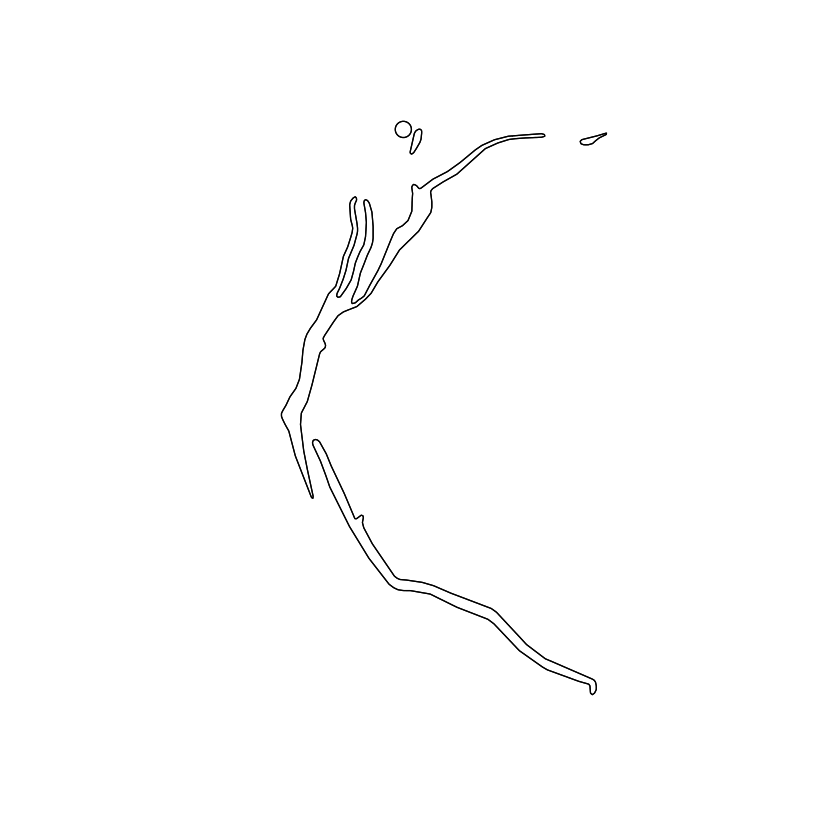

In [5]:
plot(birdrange)

In [6]:
 points <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 head(points)

,lon,lat,scientific_name
,<dbl>,<dbl>,<chr>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger


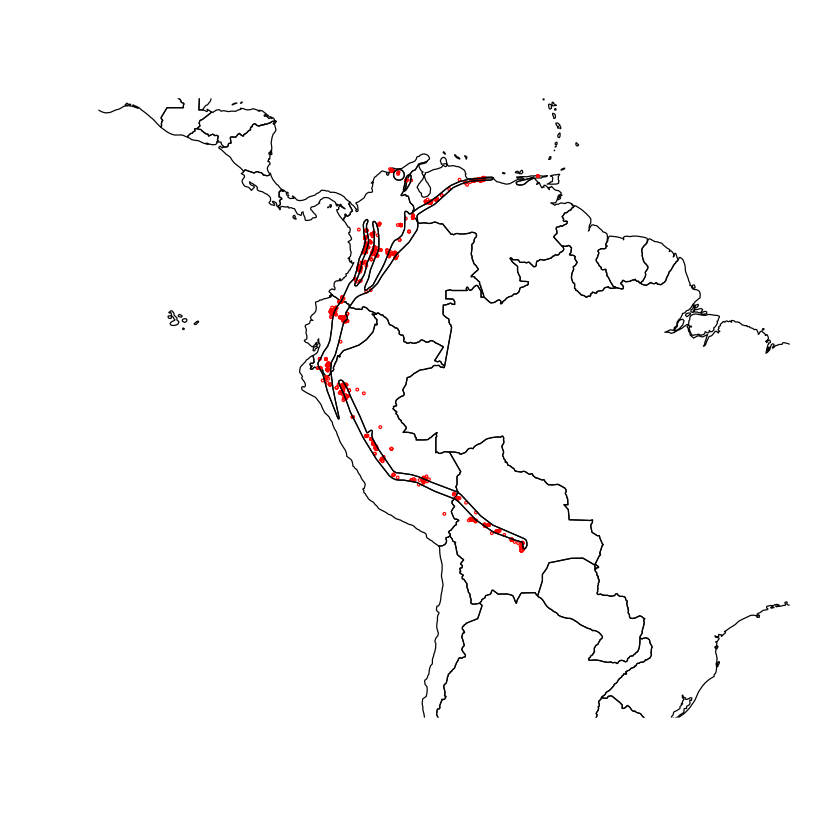

In [49]:
mapSA <- getMap(resolution = "low")
plot(mapSA, xlim = c(-80, -60), ylim = c(-30, 15), asp = 1)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [7]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [8]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


In [10]:
# building spatial dataframe
points <- SpatialPointsDataFrame(points[,c(1,2)], points)

In [12]:
class(points)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [13]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

In [14]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


Loading eBird sampling dataset, in order to obtain “absence” data

In [15]:
# link to global sampling raster
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered.tif")

In [16]:
# crop to species range to create modelling domain
sampling <- crop(gsampling,birdrange)   

In [18]:
# assign projection
projection(sampling)="+proj=longlat +datum=WGS84"

In [22]:
# convert to points within data region
samplingp <- as(sampling,"SpatialPointsDataFrame")

In [23]:
head(samplingp)

,eBirdSampling_filtered
,<dbl>
1,0
2,0
3,0
4,0
5,0
6,0


In [24]:
samplingp <- samplingp[samplingp$eBirdSampling_filtered>0,]

In [27]:
head(samplingp@data)

,eBirdSampling_filtered
,<dbl>
687,2
783,1
785,1
786,1
1241,2
2710,4


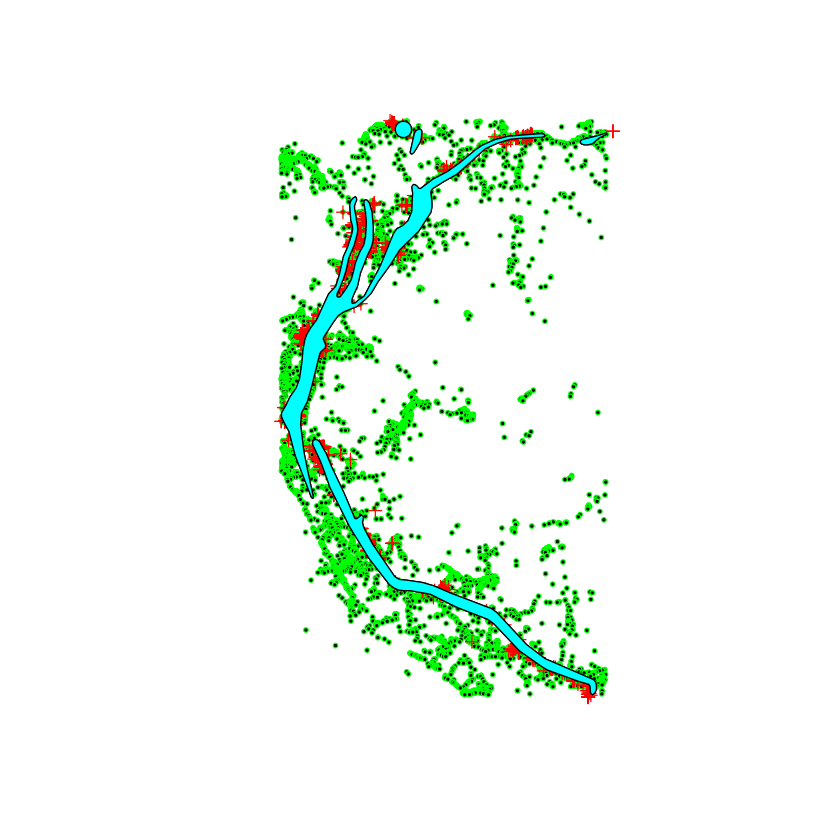

In [29]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col="cyan",add=TRUE)#species range

In [30]:
head(samplingp)

,observation,presence
,<dbl>,<dbl>
687,2,0
783,1,0
785,1,0
786,1,0
1241,2,0
2710,4,0


combine presence and non-presence point datasets

In [36]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
13188  3438 

### Read the environmental data layers

In [81]:
rCld <- raster("./geodata/cloud/SA_meanannual.tif")
rCldIA <-  raster("./geodata/cloud/SA_intra.tif")
rElv <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn.tif")
rVeg <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013.tif")

In [82]:
rVeg[rVeg < 1e-5 ] <- NA 

In [83]:
rCld <- mask(rCld, rVeg) 
rCldIA <- mask(rCldIA, rVeg) 
rElv <- mask(rElv, rVeg)

In [79]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 8400, 5880, 49392000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -83, -34, -56, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : SA_intra.1, SA_intra.2, SA_elevation_mn_GMTED2010_mn, SA_tree_mn_percentage_GFC2013 
min values :          0,          0,                         -400,                             1 
max values :       3790,      65535,                         6599,                         10000 


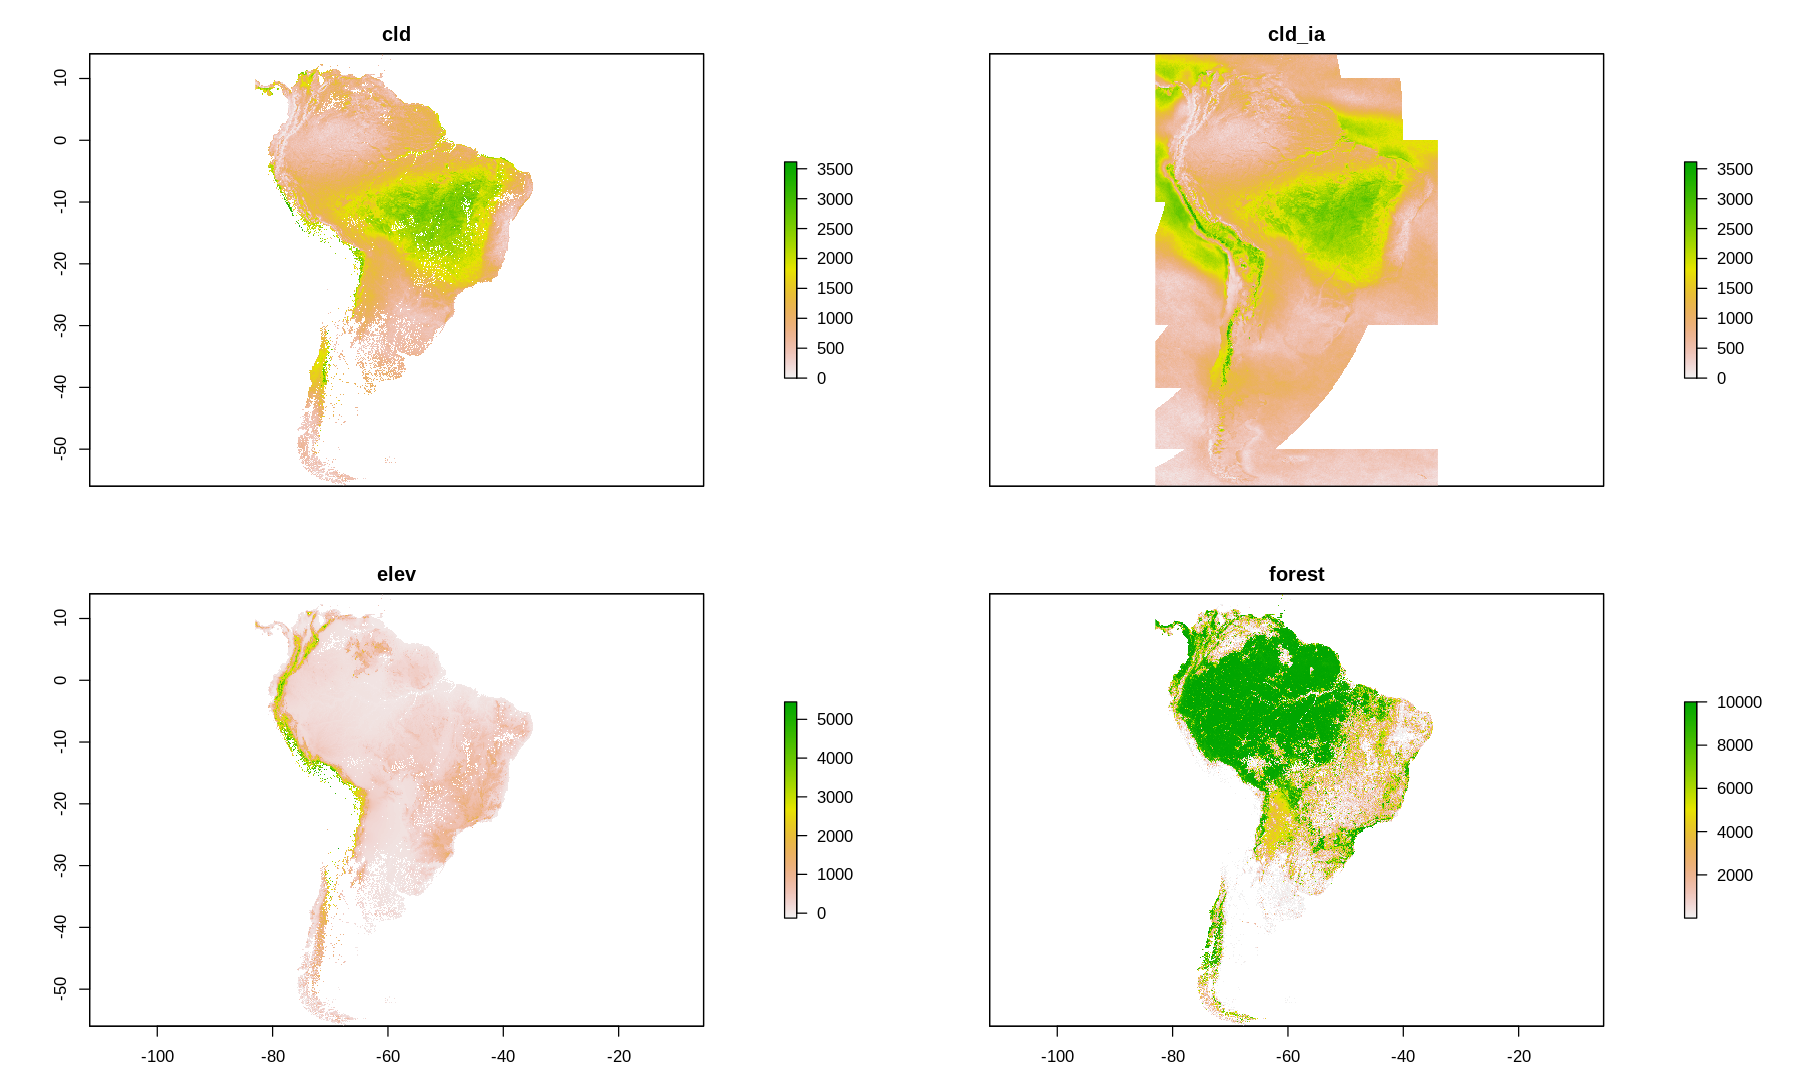

In [80]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [69]:
senv <- scale(env[[vars]])

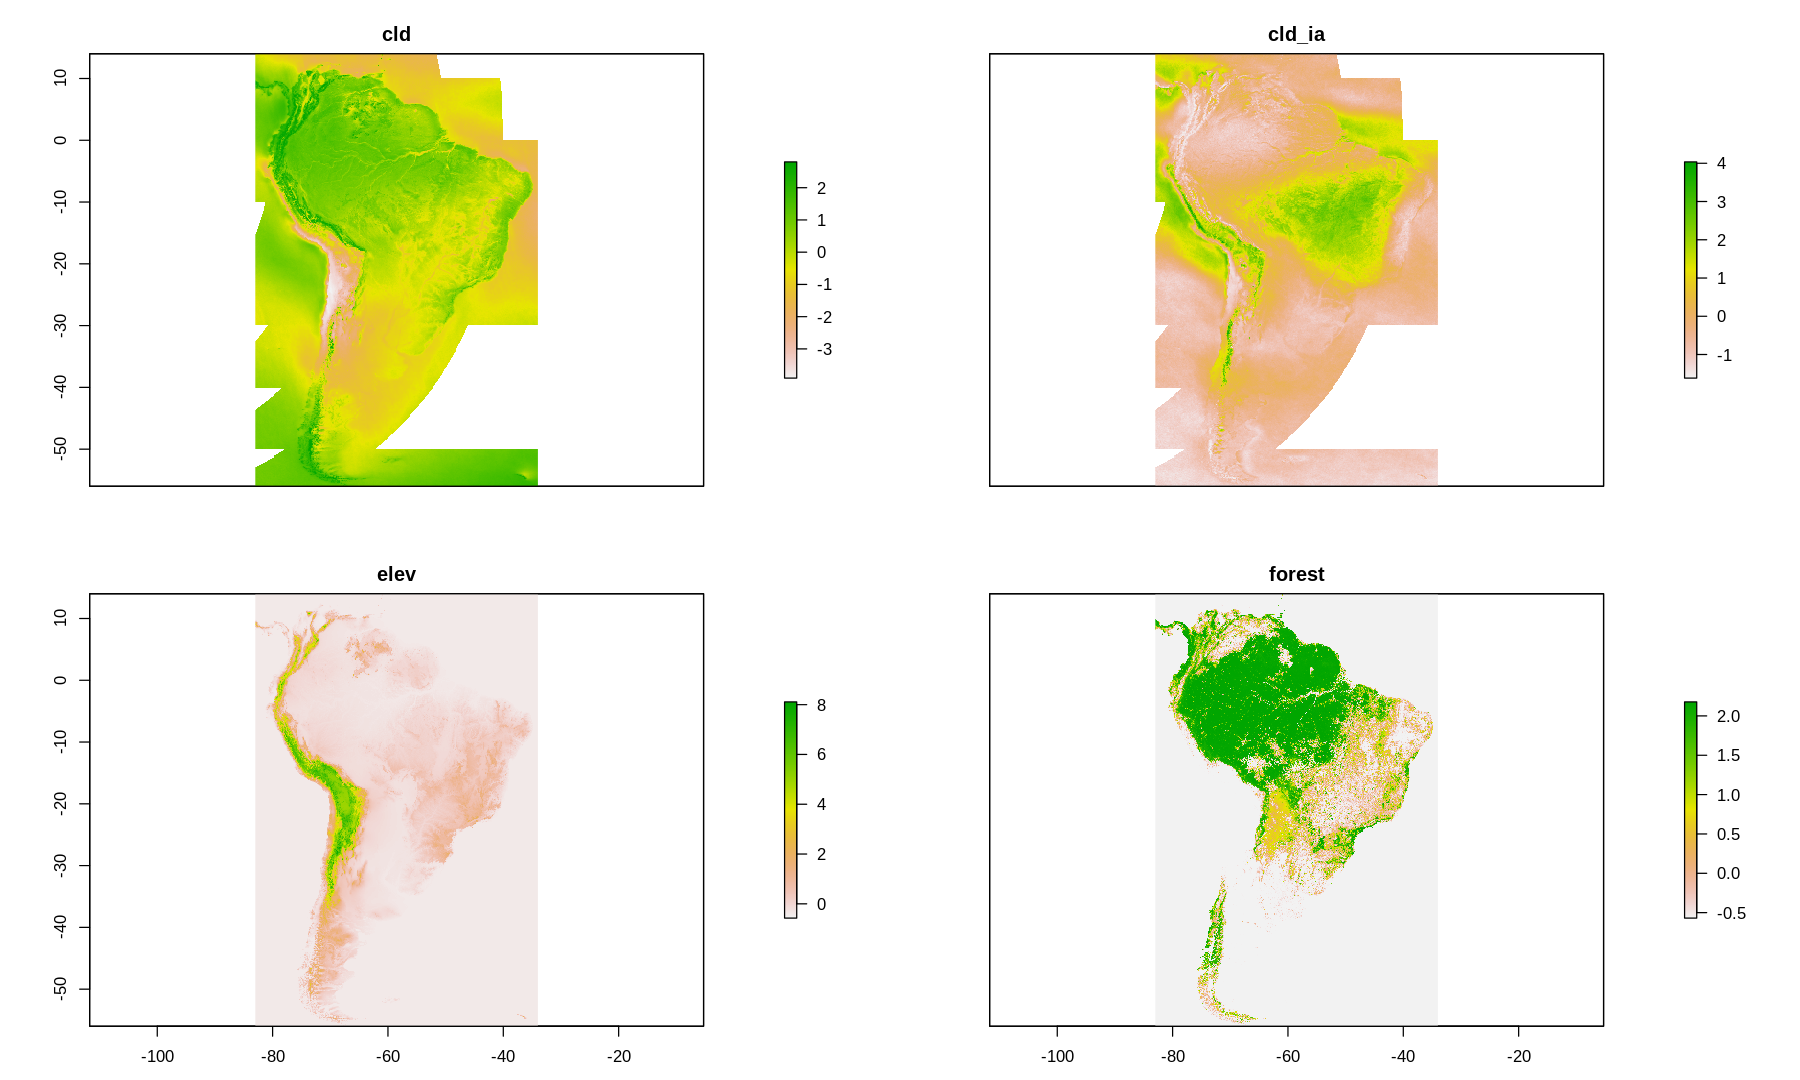

In [94]:
plot(senv)

Annotate the point records with the scaled environmental data

In [54]:
pointsd=raster::extract(senv,pdata,sp=T) 
pointsd=na.exclude(pointsd)


In [55]:
 # Look at the data table:
head(pointsd)

,presence,lon,lat,cld,cld_ia,elev,forest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-76.18925,3.98125,2.026715,-1.268168,1.439738,1.111839
2,1,-76.18406,3.93442,2.338725,-1.277550,1.935452,1.730677
3,1,-74.30256,4.60675,2.634717,-1.483954,3.365732,1.358056
4,1,-74.30256,4.60675,2.634717,-1.483954,3.365732,1.358056
5,1,-76.10394,4.74631,1.499502,-1.003907,2.098746,1.886761
6,1,-76.13861,4.74536,1.805244,-1.139947,2.155607,1.459180


### Correlation plots

In [56]:
## convert to 'long' format for easier plotting
pointsdl <- reshape::melt(pointsd@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [57]:
head(pointsdl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,3.98125,-76.18925,1,cld,2.026715
2,3.93442,-76.18406,1,cld,2.338725
3,4.60675,-74.30256,1,cld,2.634717
4,4.60675,-74.30256,1,cld,2.634717
5,4.74631,-76.10394,1,cld,1.499502
6,4.74536,-76.13861,1,cld,1.805244


In [58]:
tail(pointsdl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
66499,-18.55416,-70.32917,0,forest,-0.5696309
66500,-18.55416,-70.10417,0,forest,-0.5696309
66501,-18.55416,-70.09583,0,forest,-0.5696309
66502,-18.55416,-63.98750,0,forest,0.4374925
66503,-18.56249,-70.34583,0,forest,-0.5696309
66504,-18.56249,-69.11250,0,forest,-0.5682570


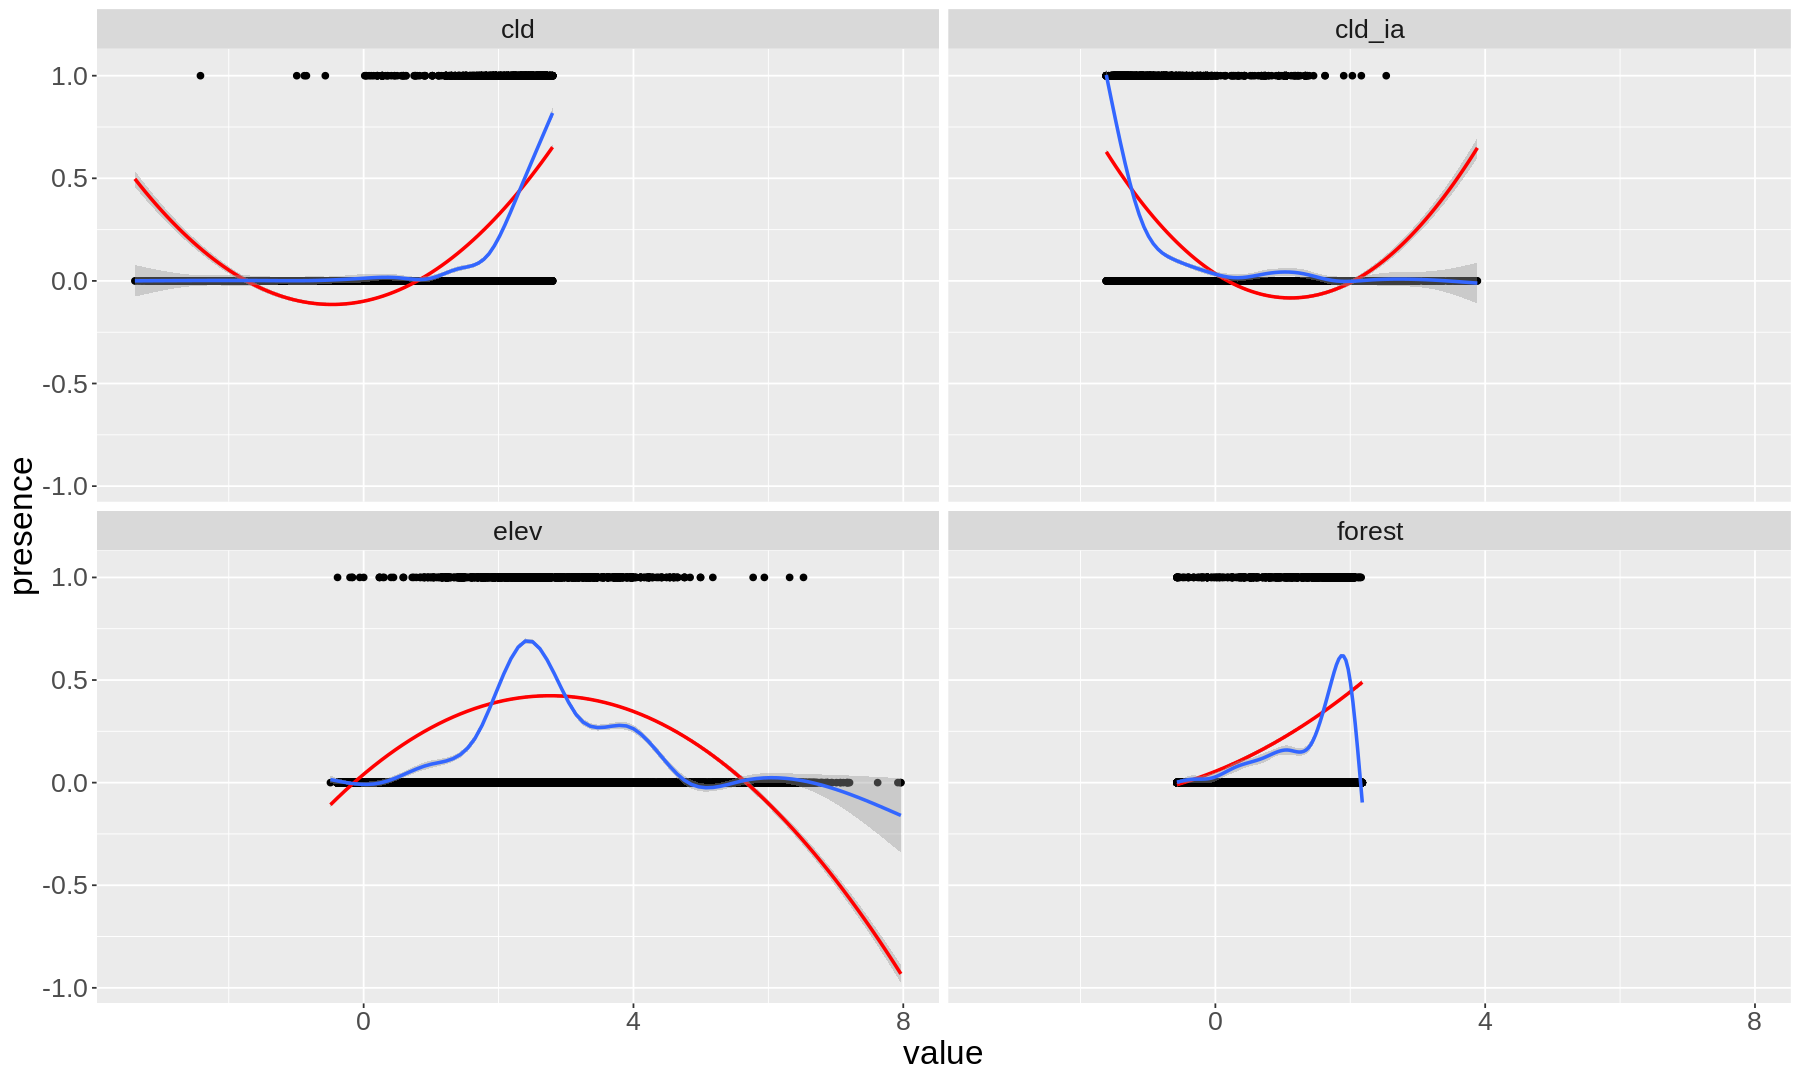

In [97]:
ggplot(pointsdl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Fitting. 

Here, we will fit a simple glm to the data. Choosing terms to include in a parametric model can be challenging, especially given the large number of possible interactions, etc. 

In this example we'll keep it fairly simple and include only a quadratic term for elevation (as suggested by the above plot). 

(Feel free to try various model formulas (adding or removing terms) and see how the model performs.)

In [101]:
pointsd <- kfold(pointsd,k=5)

[1] 2 4 1 3 2 5 3 3 3 1 4 3 4 5 3 3 1 5 2 4 1 2 2 1 3 1 1 5 4 2 1 3 4 3 2 1
   [37] 1 1 5 3 4 1 5 4 2 4 3 3 1 3 2 3 1 4 4 5 1 1 5 3 5 3 1 1 3 2 2 1 2 4 1 5
   [73] 1 4 3 1 5 5 5 3 4 3 3 5 4 4 2 1 1 1 1 4 3 1 3 3 5 2 1 5 1 3 4 5 1 2 4 3
  [109] 4 5 3 3 5 4 4 4 1 5 4 4 4 3 3 5 4 1 4 3 3 1 1 5 2 4 1 1 5 1 5 2 1 1 1 1
  [145] 2 4 1 3 4 2 1 5 5 3 3 5 3 5 3 5 5 3 5 1 5 1 3 4 2 5 1 2 1 3 1 5 3 3 2 4
  [181] 2 4 5 1 2 2 3 3 2 2 3 1 4 5 5 3 1 4 1 5 1 2 3 4 4 2 2 1 1 1 4 1 2 2 5 2
  [217] 5 5 5 4 5 1 3 5 4 1 3 1 5 1 3 5 5 2 1 5 3 1 1 3 2 1 3 5 4 3 2 1 5 5 3 4
  [253] 4 4 3 2 3 4 5 1 3 2 4 1 5 1 2 2 5 3 1 1 1 3 5 4 3 5 4 5 3 5 5 5 4 4 3 5
  [289] 4 2 2 5 3 1 1 3 5 3 3 1 2 2 4 5 5 2 1 3 1 2 3 2 3 1 3 4 4 5 3 1 2 2 2 2
  [325] 5 2 3 4 3 4 5 4 2 3 2 2 3 3 5 2 1 1 1 5 3 4 2 2 4 1 5 2 5 4 2 3 1 4 3 1
  [361] 1 5 1 1 4 1 2 1 5 4 3 1 1 3 3 4 3 4 3 5 2 2 1 2 2 1 4 2 1 1 1 1 5 2 1 2
  [397] 5 4 5 5 2 2 4 1 1 5 1 4 4 5 3 5 2 3 1 2 2 4 3 4 3 5 1 5 4 4 5 5 1 3 4 1
  [433] 3 1 2 1 4 5 4 1 5 1 1 2 2 2 1 1 3 4 2 4 1 4 5 1 5 5 2 2 3 1 4 4 5 3 2 2
  [469] 5 3 4 1 3 3 5 2 1 2 5 3 1 5 5 1 1 2 1 4 4 5 1 2 5 1 1 2 5 3 2 4 5 4 3 1
  [505] 3 5 3 3 4 4 4 3 4 3 3 2 4 5 1 3 1 3 2 2 2 2 3 2 2 3 5 3 2 4 5 1 5 4 3 4
  [541] 5 1 5 5 4 5 5 2 5 1 2 5 2 5 1 2 2 3 5 4 1 3 5 2 3 2 3 5 3 4 5 5 1 2 4 3
  [577] 4 5 2 5 1 5 2 4 1 2 4 1 4 1 3 5 2 3 4 2 1 5 4 3 3 3 3 4 1 3 4 3 4 1 4 4
  [613] 1 5 1 5 2 5 1 1 2 3 5 5 3 2 3 5 2 5 3 2 5 1 1 2 1 5 3 1 5 5 1 5 4 2 5 2
  [649] 4 2 1 5 2 3 5 3 1 2 4 2 5 1 5 1 5 2 4 5 3 1 5 4 1 1 5 2 1 5 1 2 4 2 2 2
  [685] 2 1 3 4 3 1 4 1 3 1 2 2 2 4 1 3 1 3 2 4 2 2 2 4 3 2 5 4 4 5 1 5 3 1 2 3
  [721] 2 2 1 1 5 4 1 1 4 2 1 1 1 5 5 4 4 2 1 5 5 3 4 1 2 3 1 4 2 1 3 3 3 5 3 3
  [757] 1 5 2 4 3 2 2 4 2 3 1 2 5 5 5 3 3 4 4 5 2 1 3 3 4 2 3 2 1 2 4 1 2 5 2 2
  [793] 3 3 3 2 3 1 5 4 2 3 1 1 2 5 3 5 1 2 1 4 5 3 1 2 4 4 3 4 4 5 1 2 3 4 4 5
  [829] 2 3 1 2 1 1 5 3 4 3 2 2 2 2 1 3 5 3 2 5 4 2 4 1 3 3 1 5 5 3 3 4 3 2 1 4
  [865] 4 5 1 5 3 2 5 2 4 3 3 1 4 5 2 3 4 2 2 2 3 4 3 5 2 3 3 2 1 4 3 1 4 5 3 5
  [901] 2 3 4 3 3 2 4 5 3 4 5 3 4 3 5 3 4 2 2 5 1 4 1 5 3 4 5 3 4 5 1 3 1 1 4 5
  [937] 4 4 5 3 5 2 1 3 1 2 5 2 5 5 3 5 2 4 1 1 1 5 3 3 2 2 2 3 2 3 1 5 2 1 3 4
  [973] 3 5 3 4 4 1 3 3 1 1 1 5 1 3 3 3 4 1 3 4 4 4 3 5 2 3 2 2 4 5 3 2 5 2 4 5
 [1009] 3 4 2 3 3 1 1 5 1 4 1 1 2 5 5 4 1 1 2 3 3 4 2 1 1 5 3 5 4 3 5 2 4 5 5 1
 [1045] 2 4 1 3 5 3 1 5 5 5 3 2 2 3 2 5 1 3 4 2 4 1 2 1 1 4 4 2 1 3 1 4 4 2 4 1
 [1081] 1 5 5 4 1 3 3 3 5 2 4 4 3 1 5 4 3 4 2 1 5 2 2 5 4 4 2 4 3 3 5 4 2 3 2 1
 [1117] 1 3 1 1 2 2 4 5 2 3 4 1 1 4 5 4 3 5 4 2 5 4 2 2 5 5 3 1 1 5 2 4 5 2 2 3
 [1153] 5 4 2 5 1 4 2 5 4 1 2 1 4 4 1 2 3 4 4 3 3 3 3 2 1 3 2 3 1 2 1 4 4 5 1 4
 [1189] 3 4 3 2 5 5 4 2 3 2 5 1 5 4 4 3 4 4 5 5 1 3 1 4 3 3 5 3 1 4 4 2 1 4 5 2
 [1225] 3 1 3 3 2 2 3 3 3 3 3 2 5 4 2 4 2 5 2 3 2 1 5 1 3 4 4 1 4 2 2 4 4 4 2 3
 [1261] 1 2 1 5 3 3 2 3 3 5 1 3 2 5 3 1 5 4 1 5 1 1 5 3 1 5 2 4 3 2 1 2 1 5 2 5
 [1297] 4 4 1 5 1 5 4 5 5 5 4 4 1 4 1 1 2 4 1 5 5 1 3 1 1 4 3 4 5 2 3 2 3 2 4 4
 [1333] 2 4 2 3 5 2 5 4 3 5 3 3 5 2 4 5 5 2 2 3 1 5 1 1 3 1 2 1 1 1 2 3 1 2 1 4
 [1369] 3 5 3 1 2 2 2 2 3 4 4 1 1 1 1 4 4 2 3 5 4 1 2 1 2 2 5 5 5 1 4 4 4 5 4 5
 [1405] 4 1 2 3 1 3 4 5 5 4 2 2 1 4 5 3 2 5 4 5 5 3 4 4 1 4 1 5 1 1 4 1 5 1 5 2
 [1441] 1 3 3 3 3 4 3 3 1 3 3 1 2 1 5 1 5 3 1 1 4 4 5 4 3 5 1 4 4 4 1 4 4 3 5 5
 [1477] 1 5 4 4 5 4 5 2 3 4 5 4 3 5 3 2 1 5 4 1 1 5 3 3 2 1 3 1 1 5 1 3 2 3 5 3
 [1513] 4 1 2 1 1 4 2 3 1 2 5 4 5 4 1 5 5 4 2 5 3 1 2 2 2 4 4 5 1 1 5 2 1 2 2 3
 [1549] 5 2 2 3 3 2 2 5 1 1 4 2 1 2 5 1 3 1 3 4 2 5 3 4 2 1 5 3 3 2 1 4 3 2 3 4
 [1585] 1 4 4 1 3 5 1 4 2 1 5 1 5 1 5 1 3 3 1 1 1 5 3 5 2 4 1 2 3 3 1 2 2 3 4 5
 [1621] 3 4 2 3 5 2 4 2 5 3 4 1 5 5 4 5 1 4 4 2 3 2 4 3 4 2 4 4 3 4 2 5 3 4 4 5
 [1657] 4 4 4 2 5 3 5 1 5 3 4 4 5 1 2 2 4 4 4 1 3 3 1 4 4 1 2 1 1 2 1 4 3 1 2 1
 [1693] 4 3 4 4 5 1 4 2 2 5 1 3 1 4 5 1 2 2 1 1 3 1 1 5 1 5 3 2 3 2 2 5 1 1 1 5
 [1729] 5 2 1 1 2 3 4 5 5 1 4 4 4 3 5 1 5 1 5 2 4 4 3 5 1 1 4 5 4 3 4 2 3 4 3 2
 [1765] 1 4 4 5 4 1 4 4 3 4 4 1 2 4 3 1 5 2 3 5 1 1 2 2 3 3 2 1 4 2 3 4 4 5 1 4
 [18

In [61]:
m1 <- glm(presence~cld+elev,
       data=pointsd,family=binomial(logit))

m2 <- glm(presence~cld+cld_ia+elev*I(elev^2)+forest,
       data=pointsd,family=binomial(logit))

### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [62]:
p1 <- raster::predict(senv,m1,type="response")
p2 <- raster::predict(senv,m2,type="response")
p <- stack(p1,p2); names(p)=c("Model 1","Model 2")

Plot the results as a map:

Regions defined for each Polygons



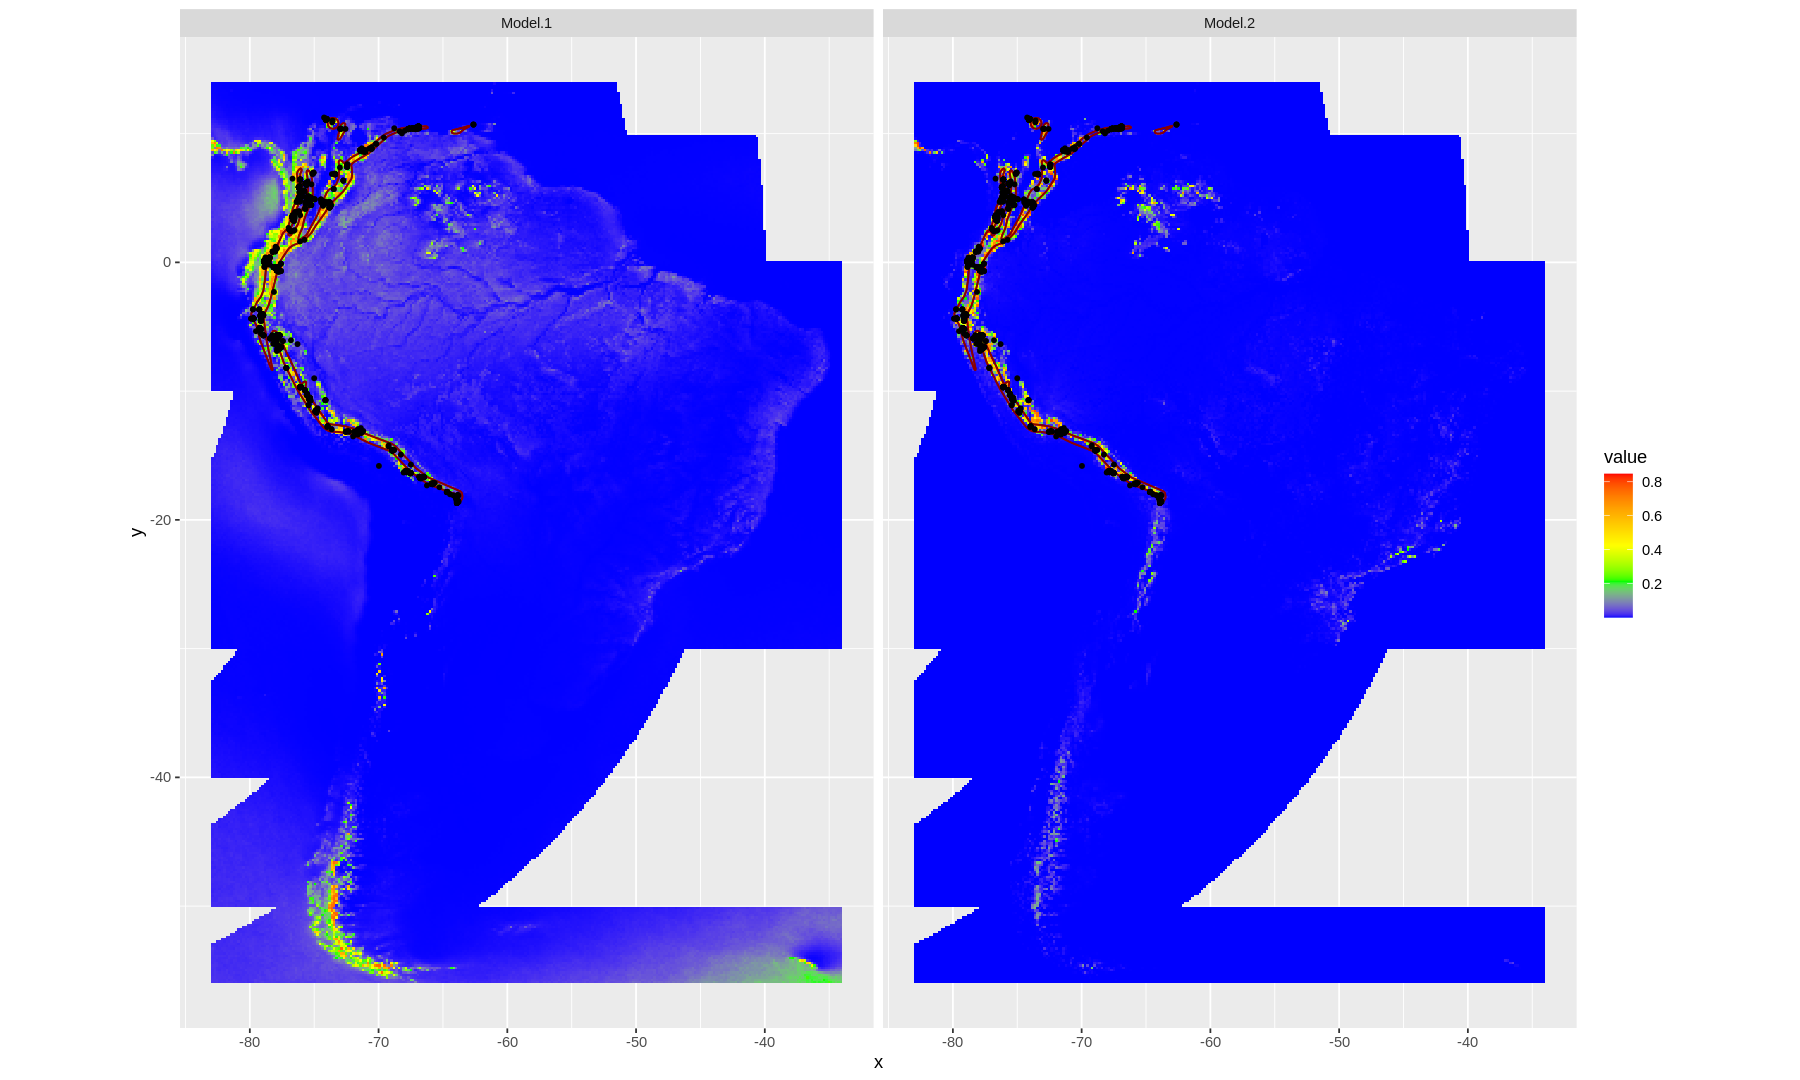

In [98]:
gplot(p,max=1e5)+geom_tile(aes(fill=value))+
  facet_wrap(~variable)+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = points@data,col="black",size=1)+
  coord_equal()

### Model Evaluation

In general, it is a good idea to use k-fold cross validation, available in 

### Assignment 

Q1. (10 %)

Load file "./geodata_small/raster.tif" into R. Aggreate it into a 5x5 matrix and compute its mean value 

Q2. (10 %)

Load database "./R_db/Doubs.RData" into R. Plot species Titi against four environmental viarbles of your choice.    

## References
